# Convolutional Network with one layer

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

/home/fernanda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset: Loading and preparation

In [2]:
# the data, split between train and test sets
(x_train, y_train_np), (x_test, y_test_np) = mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print (input_shape)

# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train_np, num_classes)
y_test = keras.utils.to_categorical(y_test_np, num_classes)

batch_size = 128
epochs = 12

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(28, 28, 1)


# Conv2D + ReLu

<img src="conv1.png">

In [3]:
model = Sequential()
# Input Layer
input_shape=input_shape
# Hidden Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten(name="bottleneck"))
model.add(Dense(512, activation='relu'))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
bottleneck (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               819712    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total para

In [4]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

In [5]:
history = model.fit(x_train, y_train, batch_size=batch_size,  epochs=epochs,  verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 20s 337us/step - loss: 0.1648 - acc: 0.9513 - val_loss: 0.0547 - val_acc: 0.9826
Epoch 2/12
60000/60000 [==============================] - 18s 298us/step - loss: 0.0442 - acc: 0.9864 - val_loss: 0.0389 - val_acc: 0.9876
Epoch 3/12
60000/60000 [==============================] - 18s 297us/step - loss: 0.0294 - acc: 0.9907 - val_loss: 0.0383 - val_acc: 0.9873
Epoch 4/12
60000/60000 [==============================] - 18s 303us/step - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0268 - val_acc: 0.9906
Epoch 5/12
60000/60000 [==============================] - 18s 302us/step - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0409 - val_acc: 0.9871
Epoch 6/12
60000/60000 [==============================] - 18s 300us/step - loss: 0.0131 - acc: 0.9958 - val_loss: 0.0282 - val_acc: 0.9907
Epoch 7/12
60000/60000 [==============================] - 18s 304us/step - loss: 0.0088 - acc: 0.9971 - val_loss: 0.

#### Features Bottleneck

In [6]:
Feature = Model(model.input, model.get_layer('bottleneck').output)
Zenc = Feature.predict(x_train)# bottleneck representation
#Renc = m.predict(x_train)        # reconstruction
Zenc_test = Feature.predict(x_test)

Feature.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
bottleneck (Flatten)         (None, 1600)              0         
Total params: 37,568
Trainable params: 37,568
Non-trainable params: 0
_________________________________________________________________


In [15]:
print (Zenc.shape, y_train_np.shape, y_train.shape)

(60000, 1600) (60000,) (60000, 10)


#### SVM

In [9]:
clf = svm.SVC(kernel = 'rbf', C = 100, gamma = 'auto', probability=False)
#clf = svm.SVC(kernel = 'rbf', C = 4, gamma = 'auto', probability=False)
clf.fit(Zenc[0:30000], y_train_np[0:30000])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Predict the response for test dataset
y_pred = clf.predict(Zenc_test)
#y_pred = clf.predict(x_test[0:30000])

In [11]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_np, y_pred))



Accuracy: 0.9922


### Matriz de Confusão

In [13]:
#confusion_mtx = confusion_matrix(y_true, Y_pred_classes) 
C = metrics.confusion_matrix(y_test_np, y_pred)
print (C)

[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1134    0    0    0    1    0    0    0    0]
 [   0    3 1023    0    1    0    1    4    0    0]
 [   1    0    1 1005    0    2    0    0    1    0]
 [   0    0    0    0  976    0    3    0    0    3]
 [   0    0    0    2    0  888    1    1    0    0]
 [   5    2    1    0    2    5  942    0    1    0]
 [   0    3    5    0    0    0    0 1020    0    0]
 [   3    0    2    1    1    0    0    1  964    2]
 [   0    1    0    2    5    4    1    3    0  993]]


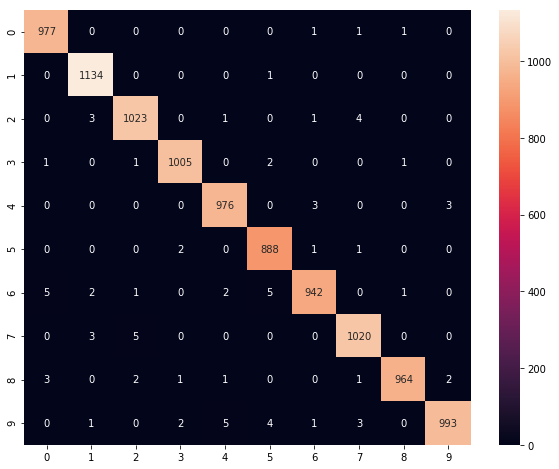

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(C, annot=True, fmt="d");

### Visualização das características extraídas pela CNN

In [ ]:
from keras.models import Model

layer_outputs = [layer.output for layer in model.layers]

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[0].reshape(1,28,28,1))
print ((activations[1].shape))

In [ ]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    #print (activation.shape)
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size,col_size))
    #print (activation.shape)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='viridis') #gray
            ax[row][col].axis('off')
            activation_index += 1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(x_train[0][:,:,0]);

In [ ]:
display_activation(activations, 8, 8, 0)
print ("1ª camada - CNN -  64 filtros")

In [ ]:
display_activation(activations, 8, 4, 1)
print ("2ª camada - Pooling")

In [ ]:
display_activation(activations, 8, 4, 2)
print ("3ª camada - CNN")

In [ ]:
display_activation(activations, 8, 4, 3)
print ("4ª camada - Pooling")

# References

- http://cs231n.github.io/convolutional-networks/
- https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras